Project Tasks:
1. Of cats and cookies
2. The AB-test data
3. The distribution of game rounds
4. Overall 1-day retention
5. 1-day retention by AB-group
6. Should we be confident in the difference?
7. Zooming in on the difference
8. The probability of a difference
9. 7-day retention by AB-group
10. Bootstrapping the difference again
11. The conclusion

In [87]:
#pip install numpy

In [88]:
#pip install seaborn

In [89]:
#pip install matplotlib

In [90]:
#pip install scipy

In [91]:
#pip install pingouin

In [92]:
#pip install pandas

In [93]:
# Base
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [94]:
# Hypothesis Testing
from scipy.stats import shapiro
import scipy.stats as stats
import pingouin as pg

In [95]:
# Configuration
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [96]:
df = pd.read_csv('cookie_cats.csv')
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


Part one. Dataframe research

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [98]:
df.isna().nunique()

userid            1
version           1
sum_gamerounds    1
retention_1       1
retention_7       1
dtype: int64

In [99]:
# Counting the number of players in each AB group.
df_ver = df.groupby('version')
df_ver.sum_gamerounds.describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


array([[<AxesSubplot: title={'center': 'sum_gamerounds'}>]], dtype=object)

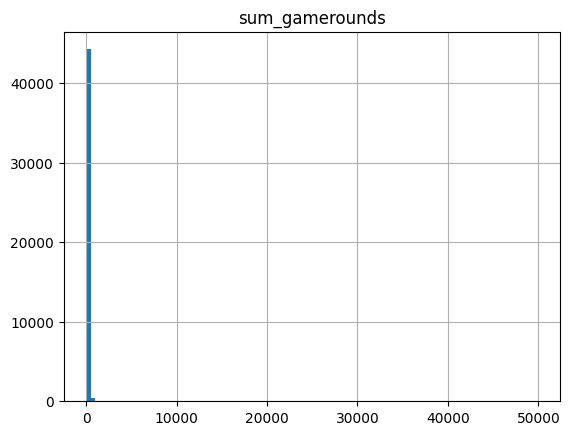

In [100]:
df[(df.version == "gate_30")].hist("sum_gamerounds", bins = 100)

array([[<AxesSubplot: title={'center': 'sum_gamerounds'}>]], dtype=object)

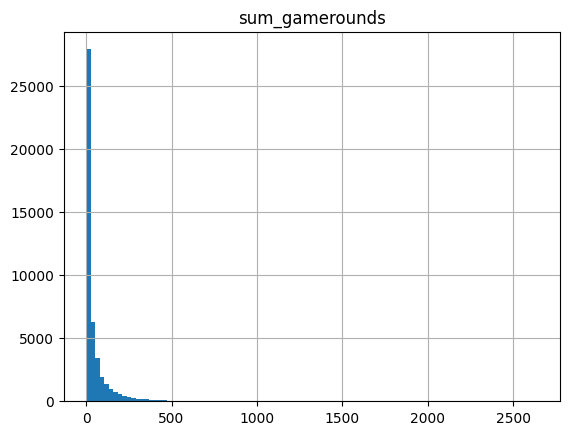

In [101]:
df[(df.version == "gate_40")].hist("sum_gamerounds", bins = 100)

<AxesSubplot: >

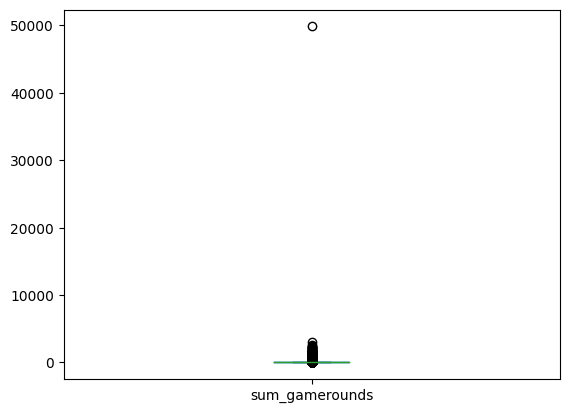

In [102]:
# Let's check the data for emissions ("whales")
df['sum_gamerounds'].plot.box()

Let's remove the outlier and see how the groups and distribution change

In [103]:
# Delete an abnormally large value
df = df[df.sum_gamerounds < df.sum_gamerounds.max()]
df.max()

userid            9999861
version           gate_40
sum_gamerounds       2961
retention_1          True
retention_7          True
dtype: object

<AxesSubplot: xlabel='version', ylabel='sum_gamerounds'>

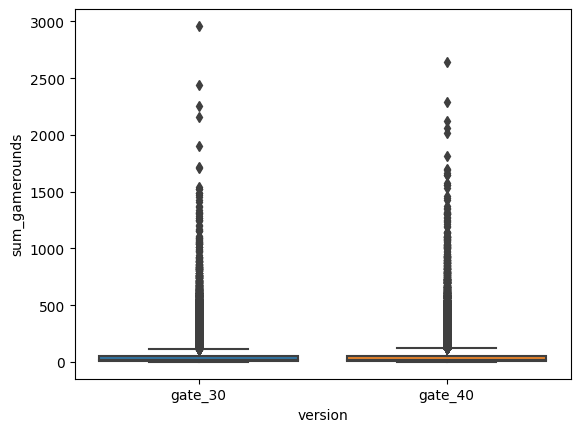

In [104]:
sns.boxplot(x = df.version, y = df.sum_gamerounds)

In [105]:
df_version = df.groupby('version')
df_version.sum_gamerounds.describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44699.0,51.342111,102.057598,0.0,5.0,17.0,50.0,2961.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


Let's check how many players did not pass the first round and how many of them returned to the game on the 1st and 7th day

In [106]:
# Let's check how many players did not pass the first round
df[df['sum_gamerounds'] == 0].userid.count()

3994

In [107]:
df_null = df.query('sum_gamerounds == 0')
df_null.query('retention_7 == True').count()

userid            29
version           29
sum_gamerounds    29
retention_1       29
retention_7       29
dtype: int64

In [108]:
df_null.query('retention_1 == True').count()

userid            87
version           87
sum_gamerounds    87
retention_1       87
retention_7       87
dtype: int64

First conclusions:
1. The number of players is roughly the same in the control and test group;
2. 50% of players played <16 rounds during the first week after installation with the 75-th percentile amounting to 51 rounds in the first week. Most of users played the game at early stage and they didn't progress;
3. The "gate_30" group contained a player who had completed about 49,854 rounds in a week. It seems to me that this is an abnormal value and it is an outlier;
4. 3994 failed the first round after installing the game. Of these, 116 players returned to the game during the week. Players who did not pass the first round can be divided into 3 types:
- Newbies who haven't logged into the game yet;
- Players who didn't like the game because of the design or setting;
- Players who could not pass the first level due to its complexity.

In [109]:
df_count_dis = df.groupby('sum_gamerounds')['userid'].count()

Text(0.5, 0, 'Count rounds')

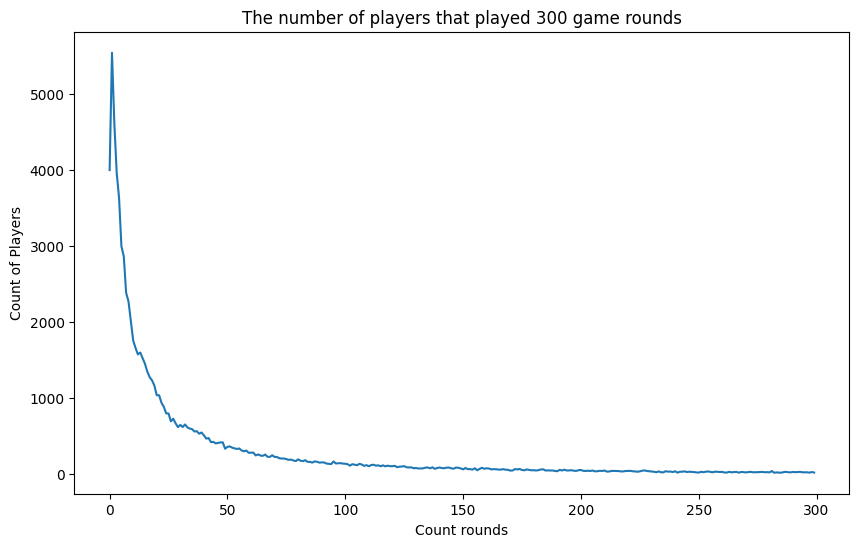

In [110]:
# Plot the distribution of players that played 0 to 300 game rounds during their first week playing the game.
ax = df_count_dis[:300].plot(figsize=(10,6))
ax.set_title("The number of players that played 300 game rounds")
ax.set_ylabel("Count of Players")
ax.set_xlabel('Count rounds')

Part two. Retention

In [111]:
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [112]:
df_gate_30 = df.query('version == "gate_30"')
df_gate_40 = df.query('version == "gate_40"')

In [122]:
rr_gate30_day1 = round((df_gate_30.query('retention_1 == True').value_counts().sum() / len(df_gate_30) *100), 2)
rr_gate40_day1 = round((df_gate_40.query('retention_1 == True').value_counts().sum() / len(df_gate_30) *100), 2)
rr_gate30_day7 = round((df_gate_30.query('retention_7 == True').value_counts().sum() / len(df_gate_30) *100), 2)
rr_gate40_day7 = round((df_gate_40.query('retention_7 == True').value_counts().sum() / len(df_gate_30) *100), 2)

In [130]:
print(f'Retention_ratio_1_day_gate30 : {rr_gate30_day1}',
      f'Retention_ratio_1_day_gate40 : {rr_gate40_day1}',
      f'Retention_ratio_7_day_gate30 : {rr_gate30_day7}',
      f'Retention_ratio_7_day_gate40 : {rr_gate40_day7}')

Retention_ratio_1_day_gate30 : 44.82 Retention_ratio_1_day_gate40 : 45.01 Retention_ratio_7_day_gate30 : 19.02 Retention_ratio_7_day_gate40 : 18.52


To be continued...